In [1]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,6)

# Initial data load

In [2]:
# Load oil data
oil_data = pd.read_csv("data/oil.csv")
oil_data["date"] = oil_data["date"].map(lambda date : datetime.strptime(date, '%Y-%m-%d'))
oil_data.set_index("date", inplace=True)
oil_data.rename(columns = {"dcoilwtico": "oil_price"}, inplace=True)

# Load holiday data
holiday_data = pd.read_csv("data/holidays_events.csv")
holiday_data["date"] = holiday_data["date"].map(lambda date : datetime.strptime(date, '%Y-%m-%d'))
holiday_data.set_index("date", inplace=True)
holiday_data.columns = [f"holiday_{x}" for x in holiday_data.columns]

# Load store metadata 
store_data = pd.read_csv("data/stores.csv", index_col="store_nbr")
store_data.columns = [f"store_{x}" for x in store_data.columns]

# Load train/test data
datasets = {
    "train": None,
    "test": None
}

# Join additional data
for group in ["train", "test"]:
    df = pd.read_csv(f"data/{group}.csv", index_col = "id")
    df["date"] = df["date"].map(lambda date : datetime.strptime(date, '%Y-%m-%d'))
    df = df.join(store_data, on="store_nbr", how="left")
    df = df.join(oil_data, on="date", how="left")
    df = df.join(holiday_data, on="date", how="left")
    datasets[group] = df

In [3]:
datasets["train"].head()

,date,store_nbr,family,sales,onpromotion,store_city,store_state,store_type,store_cluster,oil_price,holiday_type,holiday_locale,holiday_locale_name,holiday_description,holiday_transferred
id,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


# Data exploration

We have multiple time series in our dataset : one for each product family in each store.

### Basic information on the dataset

In [4]:
df = datasets["train"].copy()
n = df["store_nbr"].nunique()
m = df["family"].nunique()
print(f'Train dataset has {n} different stores and {m} different family products.')
print(df["family"].unique())
print("---")

stores_with_not_all_families = 0
for store in df["store_nbr"].unique():
    if df[df["store_nbr"]==store]["family"].nunique()!=m:
        stores_with_not_all_families+=1
if stores_with_not_all_families==0:
    print(f"All stores sell all product families -> {n*m} time series to treat.")
print("---")
 
columns_with_nans = []
for c in df.columns:
    if df[c].isna().sum().any():
        columns_with_nans.append(c)
print(f"Nan values are present in {columns_with_nans}")
print("---")

min_date = df["date"].describe(datetime_is_numeric=True)['min'].date()
max_date = df["date"].describe(datetime_is_numeric=True)['max'].date()
print(f"Date span in data : {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
      
missing_dates = list(pd.date_range(start=min_date.strftime('%Y-%m-%d'), end=max_date.strftime('%Y-%m-%d'))\
      .difference(df["date"]))
print(f"Missing dates in data : {[t.date().strftime('%Y-%m-%d') for t in missing_dates]}")

Train dataset has 54 different stores and 33 different family products.
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
---
All stores sell all product families -> 1782 time series to treat.
---
Nan values are present in ['oil_price', 'holiday_type', 'holiday_locale', 'holiday_locale_name', 'holiday_description', 'holiday_transferred']
---
Date span in data : 2013-01-01 to 2017-08-15
Missing dates in data : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


### Visualization tools

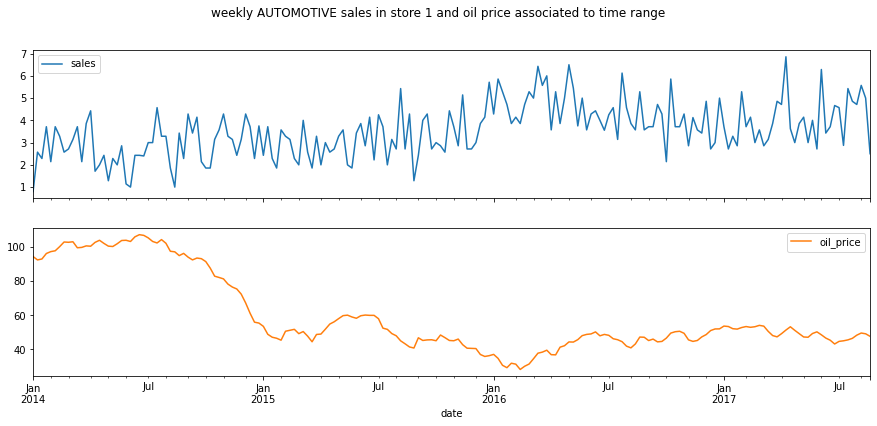

In [5]:
# Basic plot of the time series
def plot_time_series(dataset, product_family, store_nbr, min_year = None, max_year = None, freq = "D"):
    
    # Prepare dataframe for visualization
    sub_dataset = df[(df["family"]==product_family)&(df["store_nbr"]==store_nbr)]
    if min_year is not None:
        sub_dataset = sub_dataset[sub_dataset["date"].map(lambda x : x.year >= min_year)]
    if max_year is not None:
        sub_dataset = sub_dataset[sub_dataset["date"].map(lambda x : x.year <= max_year)]
    sub_dataset = sub_dataset.set_index("date").groupby(pd.Grouper(freq=freq))[["sales", "oil_price"]].mean()
        
    freq_d = {
        "D": "daily",
        "W": "weekly",
        "M": "monthly",
        "Y": "yearly"
    }
    title = f"{freq_d[freq]} {product_family} sales in store {store_nbr} and oil price associated to time range"
    plot = sub_dataset.plot(subplots=True, title=title)
    
plot_time_series(df, 
                 product_family="AUTOMOTIVE", 
                 store_nbr=1, 
                 min_year=2014, 
                 max_year=2017,
                 freq="W")

### Explaning the data (find patterns)